<a href="https://colab.research.google.com/github/acse-lj623/c-examples/blob/main/baseline_testKernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
import os
import json
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


In [5]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [6]:
big_folder_path = '/content/gdrive/MyDrive/walid/Selected_Storms_curated'

# 获取所有文件夹并按文件名数字进行排序
storm_folders = sorted([f for f in os.listdir(big_folder_path) if os.path.isdir(os.path.join(big_folder_path, f))],
                       key=lambda x: int(x.split('_')[1]) if '_' in x and x.split('_')[1].isdigit() else float('inf'))

for folder_name in storm_folders:
    folder_path = os.path.join(big_folder_path, folder_name)

    # 用于存储每个子文件夹中的时间数据和标签数据
    time_data_list = []
    label_data_list = []

    # 遍历每个子文件夹中的所有文件
    for file_name in sorted(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, file_name)

# 以下两'假设'部分可以考虑如果'假设'不成立的情况，则略过这一组数据（无效数据，防止报错）
        # 读取 features 中的 time 数据
        if 'features' in file_name:
            with open(file_path, 'r') as file:
                features_data = json.load(file)
                # 假设 features 数据中有一个字段叫 'relative_time'
                time_data_list.append(features_data.get('relative_time', None))

        # 读取 label 数据
        elif 'label' in file_name:
            with open(file_path, 'r') as file:
                label_data = json.load(file)
                # 假设 label 数据中有一个字段叫 'wind_speed'
                label_data_list.append(label_data.get('wind_speed', None))

    # 将 time_data_list 和 label_data_list 转换为 DataFrame，并添加 'storm_id' 列
    df = pd.DataFrame({'Time Data': time_data_list, 'Label Data': label_data_list, 'storm_id': folder_name})

    # 计算百分位位置
    df['pct_of_storm'] = df.groupby('storm_id').cumcount() / df.groupby('storm_id')['storm_id'].transform('size')

    # 划分训练集和验证集
    train_df = df[df['pct_of_storm'] < 0.8].drop(['pct_of_storm'], axis=1)
    val_df = df[df['pct_of_storm'] >= 0.8].drop(['pct_of_storm'], axis=1)


In [11]:
for storm_id, group in df.groupby('storm_id'):
    print(f"Storm ID: {storm_id}")
    print(group)
    print("\n")  # 添加空行分隔不同的风暴


Storm ID: bkh
    Time Data Label Data storm_id  pct_of_storm
0           0         25      bkh      0.000000
1        1801         25      bkh      0.002439
2        3600         25      bkh      0.004878
3        5400         25      bkh      0.007317
4        7200         25      bkh      0.009756
..        ...        ...      ...           ...
405   1022400         30      bkh      0.987805
406   1026001         30      bkh      0.990244
407   1027801         30      bkh      0.992683
408   1029601         30      bkh      0.995122
409   1031401         30      bkh      0.997561

[410 rows x 4 columns]




In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
import numpy as np
# 定义要搜索的核函数超参数的范围
param_dist = {
    'kernel': [
        1.0 * kernels.Matern(length_scale=1.0, length_scale_bounds=(1e-3, 1e3), nu=2.5),  # Matern内核
        1.0 * kernels.DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-3, 1e3)),  # DotProduct内核
        1.0 * kernels.ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-3, 1e3)),  # 恒定内核
        1.0 * kernels.RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-3, 1e3), alpha=1.0),  # RationalQuadratic内核

    ],
    'alpha': np.logspace(-6, 2, 10),  # 扩大 alpha 参数范围
}



gpr = GaussianProcessRegressor()

# 初始化 RandomizedSearchCV
random_search = RandomizedSearchCV(
    gpr, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1, verbose=1)

# 执行随机搜索
X_train = train_df[['Time Data']]  # 只包含 'Time Data' 列
y_train = train_df['Label Data']  # 'Label Data' 列作为目标变量

random_search.fit(X_train, y_train)

# 打印最佳核函数和超参数组合
print("Best kernel and hyperparameters:", random_search.best_params_)

# 打印最佳交叉验证分数
print("Best cross-validation score:", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best kernel and hyperparameters: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1), 'alpha': 0.00046415888336127773}
Best cross-validation score: -6.9630163176476305


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Storm bkh - Training Size: 328, Testing Size: 82
Processed Storm bkh


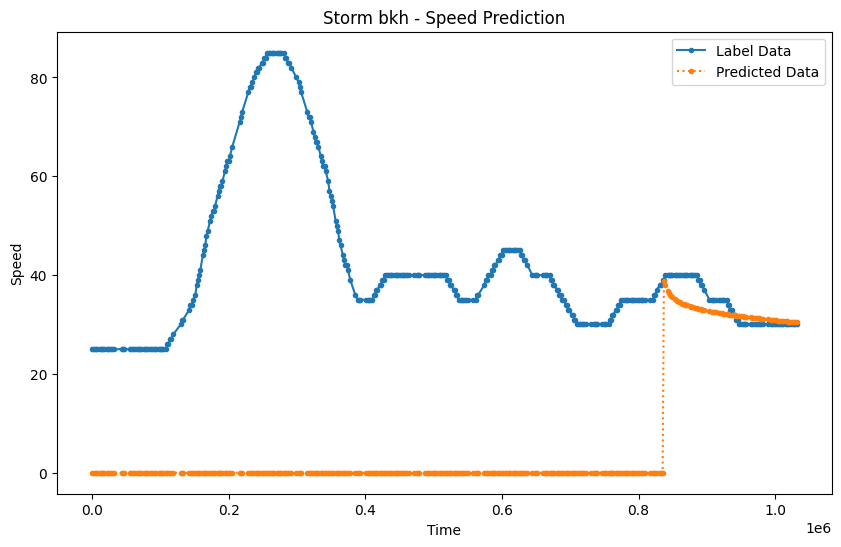

     Time Data  Label Data storm_id  predicted
0            0          25      bkh   0.000000
1         1801          25      bkh   0.000000
2         3600          25      bkh   0.000000
3         5400          25      bkh   0.000000
4         7200          25      bkh   0.000000
..         ...         ...      ...        ...
405    1022400          30      bkh  30.552148
406    1026001          30      bkh  30.504232
407    1027801          30      bkh  30.480493
408    1029601          30      bkh  30.456892
409    1031401          30      bkh  30.433428

[410 rows x 4 columns]


In [35]:
# 定义核函数
# kernel = C(1000.0, (1e-3, 1e4)) * RBF(0.1, (1e-3, 1e4))
# kernel = 1**2 * kernels.ExpSineSquared(length_scale=1, periodicity=1) * RBF(length_scale=1.0)
kernel = kernels.RationalQuadratic(alpha=1, length_scale=1)

# 定义 Gaussian Process 回归模型
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# 初始化预测结果列


df['Label Data'] = pd.to_numeric(df['Label Data'], errors='coerce')
df['Time Data'] = pd.to_numeric(df['Time Data'], errors='coerce')
df['predicted'] = 0.0

# 按照风暴分组，对每个风暴进行单独的拟合
for storm_id, group_df in df.groupby('storm_id'):
    print(f"Storm {storm_id} - Training Size: {sum(group_df['pct_of_storm'] < 0.8)}, Testing Size: {sum(group_df['pct_of_storm'] >= 0.8)}")

    X_train = group_df.loc[group_df['pct_of_storm'] < 0.8, ['Time Data']]
    y_train = group_df.loc[group_df['pct_of_storm'] < 0.8, 'Label Data']
    X_test = group_df.loc[group_df['pct_of_storm'] >= 0.8, ['Time Data']]

    # 拟合模型
    gpr.fit(X_train, y_train)

    # 预测并将结果存储到 DataFrame 中
    # df.loc[group_df[group_df['pct_of_storm'] >= 0.8].index, 'predicted'] = gpr.predict(X_test)
    df.loc[group_df[group_df['pct_of_storm'] >= 0.8].index, 'predicted'] = gpr.predict(X_test)

    # 重新从 df 中选出 group_df 以包含最新的预测值
    group_df = df[df['storm_id'] == storm_id]



    # New print statement to confirm processing of each storm
    print(f"Processed Storm {storm_id}")

# modified

    # 以下是绘图代码
    group_df = group_df.sort_values(by='Time Data')
    plt.figure(figsize=(10, 6))

    # 提取时间数据、标签数据和预测结果
    time_data = group_df['Time Data']
    label_data = group_df['Label Data']
    predicted_data = group_df['predicted']

    # 绘制标签数据
    plt.plot(time_data, label_data, label='Label Data', marker='.')

    # 绘制预测结果
    plt.plot(time_data, predicted_data, label='Predicted Data', marker='.', linestyle=':')

    # 设置图表标题、横纵坐标标签和图例
    plt.title(f'Storm {storm_id} - Speed Prediction')
    plt.xlabel('Time')
    plt.ylabel('Speed')
    plt.legend()

    # 显示图表
    plt.grid(False)
    plt.show()

# 输出结果
print(df[['Time Data', 'Label Data', 'storm_id', 'predicted']])